In [112]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
df = pd.read_csv("./film_reelgood_full.csv", encoding="utf-8")
df = df.drop(["Reelgood_Rating"], axis=1)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3357 entries, 0 to 3356
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        3357 non-null   object 
 1   IMDB_Rating  3357 non-null   float64
 2   Genres       3357 non-null   object 
 3   Year         3357 non-null   int64  
 4   Tags         3357 non-null   object 
 5   Country      3051 non-null   object 
 6   Source       3357 non-null   object 
 7   Rated        1864 non-null   object 
 8   Duration     3339 non-null   object 
 9   Description  3357 non-null   object 
 10  Director     3295 non-null   object 
 11  Employees    3357 non-null   object 
 12  User votes   3354 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 341.1+ KB


In [115]:
df.head(5)

,Title,IMDB_Rating,Genres,Year,Tags,Country,Source,Rated,Duration,Description,Director,Employees,User votes
0,Under the Shadow,6.8,"['Horror', 'Thriller']",2016,"['Ghost', 'Supernatural']",Jordan,Kanopy,13+ (PG-13),PT1H24M,After Shideh's building is hit by a missile du...,Babak Anvari,"['Narges Rashidi', 'Avin Manshadi', 'Bobby Nad...","27,192 votes"
1,Nate Bargatze: The Tennessee Kid,7.6,[],2019,[],America,Netflix,NaN,PT1H0M,A Nate Bargatze stand up comedy show for Netfl...,Ryan Polito,"['Nate Bargatze', 'Nate Bargatze']","1,815 votes"
2,Bad Seeds,7.3,"['Drama', 'Comedy']",2018,['Feel-good'],France,Netflix,18+ (R),PT1H40M,"Wael, a former street child, makes a living fr...",Kheiron,"['Kheiron', 'Catherine Deneuve', 'André Dussol...","5,444 votes"
3,A Love Story,6.4,"['Romance', 'Drama']",2007,[],Philippines,Netflix,NaN,PT1H57M,Ian Montes is a picture of success. Despite be...,Maryo J. de los Reyes,"['Maricel Soriano', 'Aga Muhlach', 'Angelica P...",142 votes
4,Joan Didion: The Center Will Not Hold,7.4,['Documentary'],2017,[],America,Netflix,NaN,PT1H32M,Griffin Dunne’s years-in-the-making documentar...,Griffin Dunne,"['Joan Didion', 'Griffin Dunne', 'Hilton Als',...","2,614 votes"


In [116]:
mlb = MultiLabelBinarizer()
df["Genres"] = df["Genres"].apply(lambda x: x.replace("'", "") if "'" in x else x)
df["Tags"] = df["Tags"].apply(lambda x: x.replace("'", "") if "'" in x else x)
df["Employees"] = df["Employees"].apply(lambda x: x.replace("'", "") if "'" in x else x)

df["Genres"] = df["Genres"].apply(lambda x: x.replace("[", "") if "[" in x else x)
df["Tags"] = df["Tags"].apply(lambda x: x.replace("[", "") if "[" in x else x)
df["Employees"] = df["Employees"].apply(lambda x: x.replace("[", "") if "[" in x else x)

df["Genres"] = df["Genres"].apply(lambda x: x.replace("]", "") if "]" in x else x)
df["Tags"] = df["Tags"].apply(lambda x: x.replace("]", "") if "]" in x else x)
df["Employees"] = df["Employees"].apply(lambda x: x.replace("]", "") if "]" in x else x)

df["Genres"] = df["Genres"].apply(lambda x: x + 'empty' if not x else x)
df["Tags"] = df["Tags"].apply(lambda x: x + 'empty' if not x else x)
df["Employees"] = df["Employees"].apply(lambda x: x + 'empty' if not x else x)

# explode genres
df = df.join(
            pd.DataFrame(
                mlb.fit_transform(df['Genres'].str.split(', ')),
                index=df.index,
                columns="Genre_" + mlb.classes_))

# # explode tags 
# df = df.join(
#             pd.DataFrame(
#                 mlb.fit_transform(df.pop('Tags').str.split(', ')),
#                 index=df.index,
#                 columns="Tag_" + mlb.classes_))

# convert user votes to number
df["User votes"] = df["User votes"].astype(str)
df['User votes'] = df['User votes'].apply(lambda x: int(x.replace(",", "").split(" ")[0].strip()) if 'nan' not in x else 0)

# convert duration to number
df["Duration"] = df["Duration"].astype(str)
def convert_to_minutes(str_duration): 
    if str_duration != 'nan':
        str_duration = str_duration[2:].replace("M", "")
        if "H" in str_duration:
            arr_time = str_duration.split("H")
            return int(arr_time[0]) * 60 + int(arr_time[1])
        else:
            return int(str_duration)
    else: return 0
df['Duration'] = df['Duration'].apply(lambda x: convert_to_minutes(x))


In [117]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3357 entries, 0 to 3356
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Title                     3357 non-null   object 
 1   IMDB_Rating               3357 non-null   float64
 2   Genres                    3357 non-null   object 
 3   Year                      3357 non-null   int64  
 4   Tags                      3357 non-null   object 
 5   Country                   3051 non-null   object 
 6   Source                    3357 non-null   object 
 7   Rated                     1864 non-null   object 
 8   Duration                  3357 non-null   int64  
 9   Description               3357 non-null   object 
 10  Director                  3295 non-null   object 
 11  Employees                 3357 non-null   object 
 12  User votes                3357 non-null   int64  
 13  Genre_Action & Adventure  3357 non-null   int32  
 14  Genre_An

,Title,IMDB_Rating,Genres,Year,Tags,Country,Source,Rated,Duration,Description,...,Genre_Horror,Genre_LGBTQ,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Science-Fiction,Genre_Sport,Genre_Stand-up & Talk,Genre_Thriller,Genre_empty
0,Under the Shadow,6.8,"Horror, Thriller",2016,"Ghost, Supernatural",Jordan,Kanopy,13+ (PG-13),84,After Shideh's building is hit by a missile du...,...,1,0,0,0,0,0,0,0,1,0
1,Nate Bargatze: The Tennessee Kid,7.6,empty,2019,empty,America,Netflix,NaN,60,A Nate Bargatze stand up comedy show for Netfl...,...,0,0,0,0,0,0,0,0,0,1
2,Bad Seeds,7.3,"Drama, Comedy",2018,Feel-good,France,Netflix,18+ (R),100,"Wael, a former street child, makes a living fr...",...,0,0,0,0,0,0,0,0,0,0
3,A Love Story,6.4,"Romance, Drama",2007,empty,Philippines,Netflix,NaN,117,Ian Montes is a picture of success. Despite be...,...,0,0,0,0,1,0,0,0,0,0
4,Joan Didion: The Center Will Not Hold,7.4,Documentary,2017,empty,America,Netflix,NaN,92,Griffin Dunne’s years-in-the-making documentar...,...,0,0,0,0,0,0,0,0,0,0


<h2>Top 20 phim được đánh giá cao nhất</h2>

In [118]:
top20_films = df.sort_values(by='IMDB_Rating', ascending=False)[:20]

Text(0.5, 0.98, 'Most popular genres')

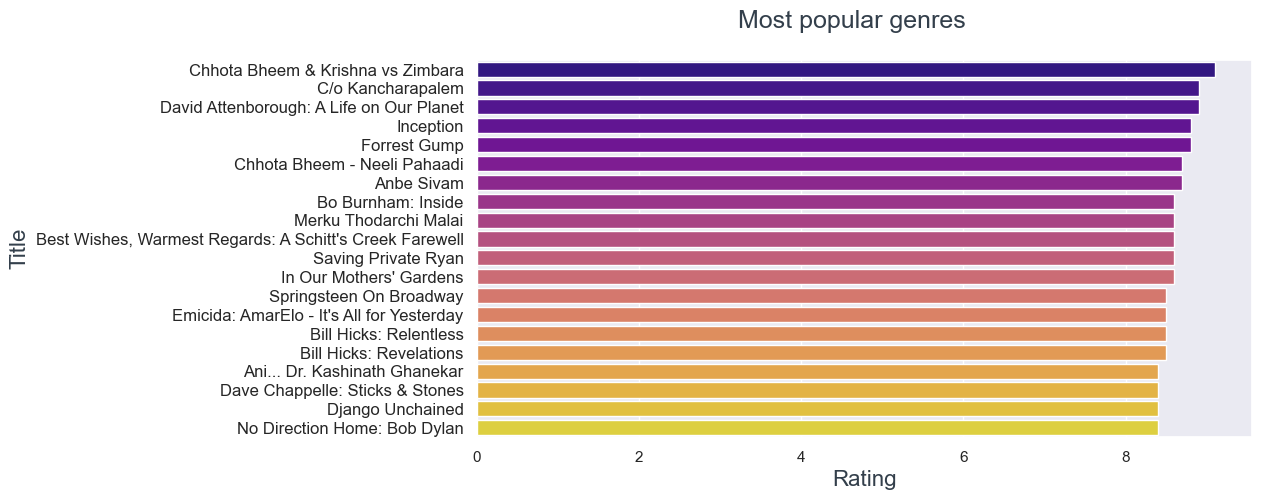

In [119]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
plt.yticks(size=12)
sns.set(style="darkgrid")
# plot the data
sns.barplot(data=top20_films, x='IMDB_Rating', y='Title', palette='plasma')
# set x and y-axis labels and title
ax.set_xlabel('Rating', fontsize=16, color = '#333F4B')
ax.set_ylabel('Title', fontsize=16, color = '#333F4B')
fig.suptitle('Most popular genres',fontsize=18, color = '#333F4B')

<h2>Phần lớn các bộ phim được đánh giá như thế nào?</h2>

d:\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


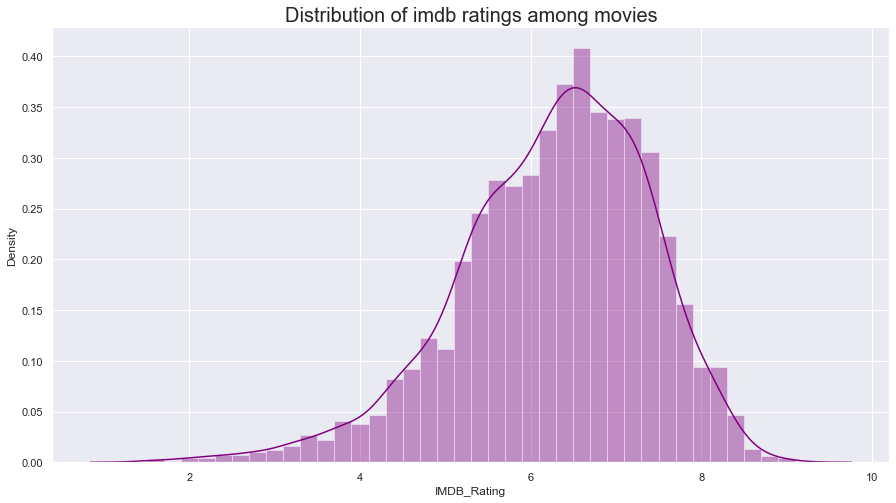

In [120]:
fig, ax = plt.subplots(figsize = (15,8))
sns.distplot(df['IMDB_Rating'], color="purple");
plt.title("Distribution of imdb ratings among movies", size = 20);

<h2>Tần suất phát hành phim qua các năm</h2>

In [121]:
years = []
df['Year'].apply(lambda x: years.append(x))
unique, counts = np.unique(years, return_counts=True)
year_dataframe = pd.DataFrame({"unique":unique,"counts":counts})
year_dataframe = year_dataframe.sort_values(['counts'],ascending=[False])

Text(0.5, 0.98, 'Movie release frequency by years')

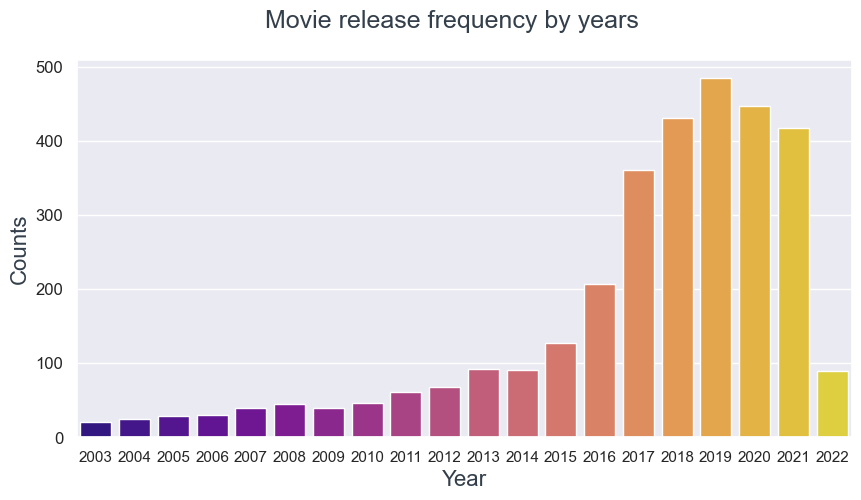

In [122]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
plt.yticks(size=12)
sns.set(style="darkgrid")
# plot the data
sns.barplot(data=year_dataframe[:20], x='unique', y='counts', palette='plasma')
# set x and y-axis labels and title
ax.set_xlabel('Year', fontsize=16, color = '#333F4B')
ax.set_ylabel('Counts', fontsize=16, color = '#333F4B')
fig.suptitle('Movie release frequency by years',fontsize=18, color = '#333F4B')

<h2>Most popular genres</h2>

In [123]:
genres = []
df['Genres'].apply(lambda x: genres.append(str(x).split(", ")))
all_genres = np.array([genre for sub_list in genres for genre in sub_list])
unique, counts = np.unique(all_genres, return_counts=True)
genre_dataframe = pd.DataFrame({"unique":unique,"counts":counts})
genre_dataframe = genre_dataframe.sort_values(['counts'],ascending=[False])

Text(0.5, 0.98, 'Most popular genres')

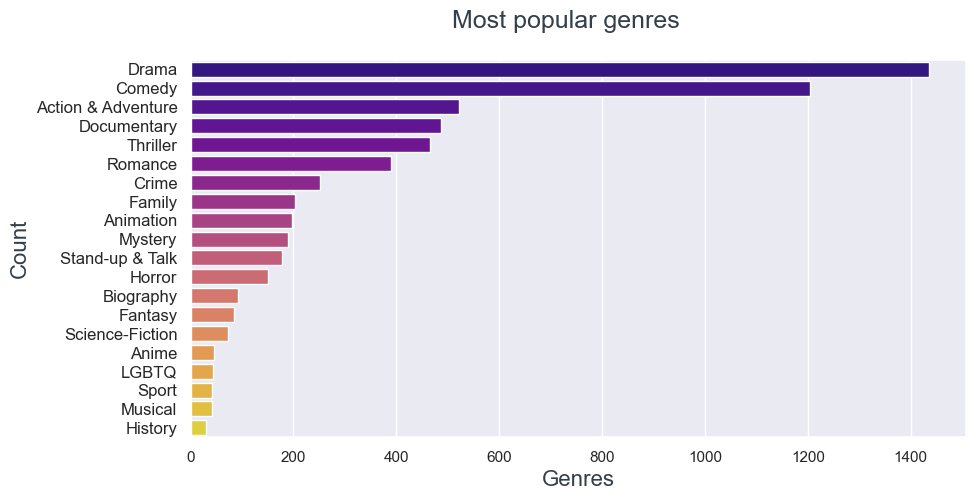

In [124]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
plt.yticks(size=12)
sns.set(style="darkgrid")
# plot the data
sns.barplot(data=genre_dataframe[:20], x='counts', y='unique', palette='plasma')
# set x and y-axis labels and title
ax.set_xlabel('Genres', fontsize=16, color = '#333F4B')
ax.set_ylabel('Count', fontsize=16, color = '#333F4B')
fig.suptitle('Most popular genres',fontsize=18, color = '#333F4B')

<h2>Rating of each genre</h2>

In [204]:
genre_df = df.loc[:, df.columns.str.startswith('Genre')].join(df['IMDB_Rating'])
genre_df = genre_df.drop(['Genre_empty'], axis=1)

# create dict
dict_genre = {}
for column in genre_df.columns[1:-1]:
    dict_genre[column] = np.array([])

# add imdb rating each genre into dict 
def add_rating(x):
    for i in x[1:-1].keys():
        if x[i] == 1:
            dict_genre[i] = np.append(dict_genre[i], x[-1])
genre_df.apply(lambda x: add_rating(x), axis=1)

# calc mean
for i in dict_genre:
    dict_genre[i] = np.mean(dict_genre[i])

dict_df = pd.DataFrame.from_dict(dict_genre, orient='index')
dict_df["Genre"] = dict_df.index

Text(0.5, 0.98, 'Most popular genres')

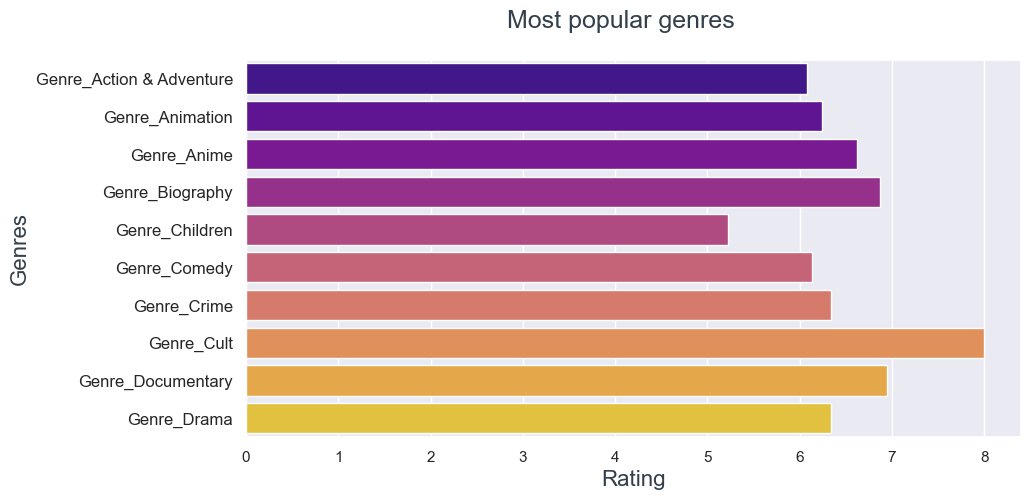

In [211]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
plt.yticks(size=12)
sns.set(style="darkgrid")
# plot the data
sns.barplot(data=dict_df[:10], x=0, y="Genre", palette='plasma')
# set x and y-axis labels and title
ax.set_xlabel('Rating', fontsize=16, color = '#333F4B')
ax.set_ylabel('Genres', fontsize=16, color = '#333F4B')
fig.suptitle('Most popular genres',fontsize=18, color = '#333F4B')

<h2>Top 10 movie release countries</h2>

In [ ]:
languages = []
df['Country'].apply(lambda x: languages.append(x) if str(x).strip() != 'nan' else None)
unique_language, counts_language = np.unique(languages, return_counts=True)
language_dataframe = pd.DataFrame({"unique":unique_language,"counts":counts_language})
language_dataframe = language_dataframe.sort_values(['counts'],ascending=[False])

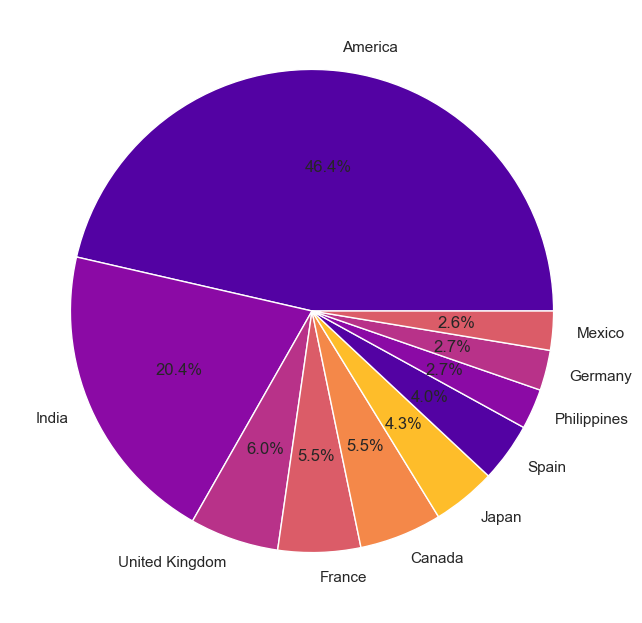

In [ ]:
data = language_dataframe['counts'][0:10]
labels = language_dataframe['unique'][0:10]

#define Seaborn color palette to use
colors = sns.color_palette('plasma')

#create pie chart
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
plt.pie(data, labels = labels, colors = colors, autopct="%.1f%%");

<img src="https://media3.giphy.com/media/3oEhmI1Y4GlCPczg1W/giphy.gif?cid=ecf05e476ac1hr00h22jjqjyaf2qxdro1fr34kicsk1d1k5h&rid=giphy.gif&ct=g" style="display:block; width: 50%; margin: 0 auto" alt="gif" />

<h2>How long are the movies?</h2>

d:\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


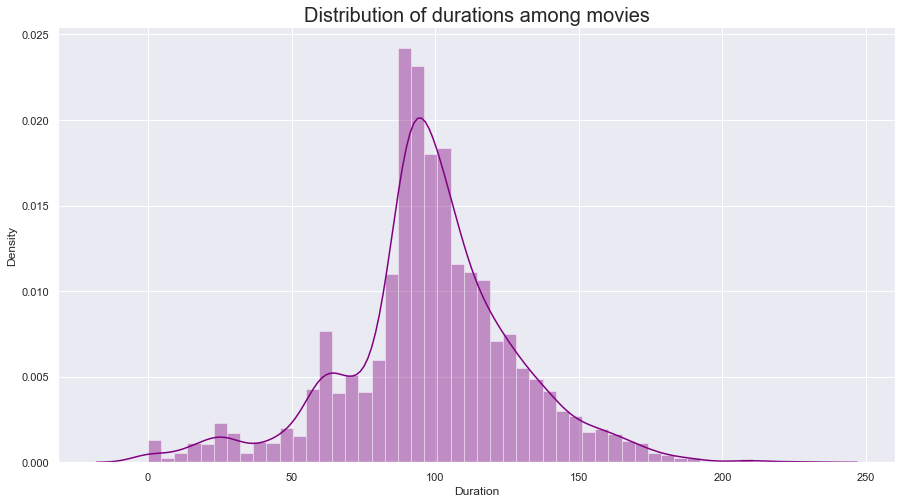

In [207]:
fig, ax = plt.subplots(figsize = (15,8))
sns.distplot(df['Duration'], color="purple");
plt.title("Distribution of durations among movies", size = 20);

<h2>Correlation of duration and IMDB rating</h2>

<AxesSubplot:xlabel='Duration', ylabel='IMDB_Rating'>

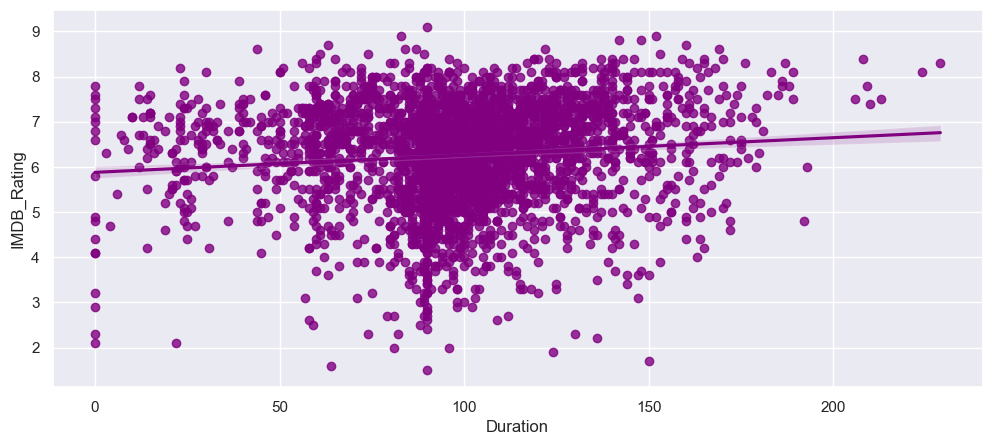

In [208]:
fig, ax1 = plt.subplots(figsize=(12, 5), dpi=100)
sns.set(style="darkgrid")
# plot data
sns.regplot(data=df, x='Duration', y='IMDB_Rating', color='purple', ax=ax1)